In [1]:
import onnx
from finn.util.basic import make_build_dir
from finn.util.visualization import showSrc, showInNetron

import torch

from finn.util.test import get_test_model_trained
import brevitas.onnx as bo
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from torch.nn import Module, ModuleList, BatchNorm2d, MaxPool2d, BatchNorm1d
from QuantLenetV2 import *
from brevitas.nn import QuantConv2d, QuantIdentity, QuantLinear
from brevitas.core.restrict_val import RestrictValueType
from brevitas_examples.bnn_pynq.models.common import CommonWeightQuant, CommonActQuant
from brevitas.core.restrict_val import RestrictValueType
from brevitas_examples.bnn_pynq.models.tensor_norm import TensorNorm

from finn.transformation.streamline import Streamline
from finn.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from finn.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants
from finn.transformation.infer_data_layouts import InferDataLayouts
from finn.transformation.general import RemoveUnusedTensors

import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten
from finn.custom_op.registry import getCustomOp
from finn.transformation.infer_data_layouts import InferDataLayouts


import netron

stopit = lambda: netron.stop(8081, "0.0.0.0")

from brevitas.core.scaling import ScalingImplType
from brevitas.core.stats import StatsOp
from brevitas.nn import QuantReLU
from brevitas.core.quant import QuantType

In [2]:
INPUT_WIDTH = 8
WEIGHT_WIDTH = 2
ACT_WIDTH = 2
MODEL_PREFIX = f"model_i{INPUT_WIDTH}_w{WEIGHT_WIDTH}_a{ACT_WIDTH}"

model = cnv(INPUT_WIDTH,WEIGHT_WIDTH,ACT_WIDTH,num_classes=10, in_channels=1)
# from QuantLeNet import QuantLeNet
# model = QuantLeNet(INPUT_WIDTH, WEIGHT_WIDTH, ACT_WIDTH)
path=f"./models/model_i{INPUT_WIDTH}_w{WEIGHT_WIDTH}_a{ACT_WIDTH}.pth"
model.load_state_dict(torch.load(path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [3]:
build_dir = './onnx'

bo.export_finn_onnx(model, (1, IN_CH, IMG_WIDTH, IMG_HEIGHT), build_dir + f"/{MODEL_PREFIX}_export.onnx")
model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_export.onnx")
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())
model.save(build_dir + f"/{MODEL_PREFIX}_tidy.onnx")

showInNetron(build_dir+f"/{MODEL_PREFIX}_tidy.onnx")

/workspace/finn/notebooks/LeNet/QuantLenetV2.py:92: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = 2.0 * x - torch.tensor([1.0], device=x.device)


Serving './onnx/model_i8_w2_a2_tidy.onnx' at http://0.0.0.0:8081


In [4]:
from finn.util.pytorch import ToTensor
from finn.transformation.merge_onnx_models import MergeONNXModels
from finn.core.datatype import DataType

model = ModelWrapper(build_dir+f"/{MODEL_PREFIX}_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)

# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = build_dir+f"/{MODEL_PREFIX}_preproc.onnx"
bo.export_finn_onnx(totensor_pyt, ishape, chkpt_preproc_name)

# join preprocessing and core model
pre_model = ModelWrapper(chkpt_preproc_name)
model = model.transform(MergeONNXModels(pre_model))

# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType.UINT8)

from finn.transformation.insert_topk import InsertTopK
from finn.transformation.infer_datatypes import InferDataTypes

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = build_dir+f"/{MODEL_PREFIX}_pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(build_dir+f"/{MODEL_PREFIX}_pre_post.onnx")

/workspace/finn/src/finn/transformation/infer_data_layouts.py:113: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")



Stopping http://0.0.0.0:8081
Serving './onnx/model_i8_w2_a2_pre_post.onnx' at http://0.0.0.0:8081


In [5]:
model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_pre_post.onnx")
model = model.transform(MoveScalarLinearPastInvariants())
model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())

# quantization width greater than 1, so we don't do this
model = model.transform(ConvertBipolarMatMulToXnorPopcount())

model = model.transform(Streamline())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())
model.save(build_dir + f"/{MODEL_PREFIX}_streamlined.onnx")
showInNetron(build_dir+f"/{MODEL_PREFIX}_streamlined.onnx")


Stopping http://0.0.0.0:8081
Serving './onnx/model_i8_w2_a2_streamlined.onnx' at http://0.0.0.0:8081


In [100]:
# choose the memory mode for the MVTU units, decoupled or const
mem_mode = "decoupled"

model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_streamlined.onnx")

# Not doing Binary Streaming FC Layer because we don't have a BNN
model = model.transform(to_hls.InferBinaryStreamingFCLayer(mem_mode))
model = model.transform(to_hls.InferQuantizedStreamingFCLayer(mem_mode))

# TopK to LabelSelect
model = model.transform(to_hls.InferLabelSelectLayer())
# # input quantization (if any) to standalone thresholding
model = model.transform(to_hls.InferThresholdingLayer())
model = model.transform(to_hls.InferConvInpGen())
model = model.transform(to_hls.InferStreamingMaxPool())
# # get rid of Reshape(-1, 1) operation between hlslib nodes
model = model.transform(RemoveCNVtoFCFlatten())
# # get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())
# infer tensor data layouts

# model = model.transform(InferDataLayouts())
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(build_dir + f"/{MODEL_PREFIX}_dataflow_parent.onnx")
showInNetron(build_dir + f"/{MODEL_PREFIX}_dataflow_parent.onnx")

Serving './onnx/model_i8_w2_a2_dataflow_parent.onnx' at http://0.0.0.0:8081


In [7]:
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
# save the dataflow partition with a different name for easier access
dataflow_model = ModelWrapper(dataflow_model_filename)
dataflow_model.save(build_dir + f"/{MODEL_PREFIX}_dataflow_model.onnx")
showInNetron(build_dir + f"/{MODEL_PREFIX}_dataflow_model.onnx")


Stopping http://0.0.0.0:8081
Serving './onnx/model_i8_w2_a2_dataflow_model.onnx' at http://0.0.0.0:8081


In [8]:
# Auto-folding did not succeed. It resulted in an error further downstream
# from finn.transformation.fpgadataflow.set_folding import SetFolding

model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_dataflow_model.onnx")

fc_layers = model.get_nodes_by_op_type("StreamingFCLayer_Batch")
# print(len(fc_layers))

# print (fc_layers[2])

folding = [
    (16, 1, 128),
    (16, 16, 128),
    (16, 16, 128),
    (16, 16, 128),
    (1, 16, 2),
    (1, 4, 2),
    (1, 8, 128),
    (5, 1, 1),
]
for fcl, (pe, simd, ififodepth) in zip(fc_layers, folding):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepth", ififodepth)

# use same SIMD values for the sliding window operators
swg_layers = model.get_nodes_by_op_type("ConvolutionInputGenerator")
for i in range(len(swg_layers)):
    swg_inst = getCustomOp(swg_layers[i])
    simd = folding[i][1]
    swg_inst.set_nodeattr("SIMD", simd)

model = model.transform(GiveUniqueNodeNames())

# folded_model = dataflow_model.transform(SetFolding())
model.save(build_dir + f"/{MODEL_PREFIX}_folded.onnx")
showInNetron(build_dir + f"/{MODEL_PREFIX}_folded.onnx")


Stopping http://0.0.0.0:8081
Serving './onnx/model_i8_w2_a2_folded.onnx' at http://0.0.0.0:8081


In [9]:
stopit()


Stopping http://0.0.0.0:8081


In [38]:
test_pynq_board = "Pynq-Z2"
target_clk_ns = 10
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild
model = ModelWrapper(build_dir+ f"/{MODEL_PREFIX}_folded.onnx")
model = model.transform(ZynqBuild(platform = test_pynq_board, period_ns = target_clk_ns))
model.save(build_dir +  f"/{MODEL_PREFIX}_synth.onnx")

KeyboardInterrupt: 

In [62]:
import os
from finn.transformation.fpgadataflow.make_deployment import DeployToPYNQ

# set up the following values according to your own environment
# FINN will use ssh to deploy and run the generated accelerator
ip = os.getenv("PYNQ_IP", "192.168.254.35")
username = os.getenv("PYNQ_USERNAME", "xilinx")
password = os.getenv("PYNQ_PASSWORD", "xilinx")
port = os.getenv("PYNQ_PORT", 22)
target_dir = os.getenv("PYNQ_TARGET_DIR", "/home/xilinx/finn_cnv_end2end_example")
ipAdd = "192.168.254.35"

model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_synth.onnx")
model = model.transform(DeployToPYNQ(ipAdd, port, username, password, target_dir))
model.save(build_dir + f"/{MODEL_PREFIX}_pynqZ2_deploy.onnx")

In [63]:
target_dir_pynq = target_dir + "/" + model.get_metadata_prop("pynq_deployment_dir").split("/")[-1]
target_dir_pynq

'/home/xilinx/finn_dev_nojan/pynq_deployment_xnf6m4pl'

In [99]:
! sshpass -p {password} ssh {username}@192.168.254.35 -p {port} 'ls -l {target_dir_pynq}'

total 4232
-rw-r--r-- 1 xilinx xilinx    8512 Dec 16 04:45 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Dec 16 03:55 finn
-rw-r--r-- 1 xilinx xilinx    3264 Dec 16 04:49 input.npy
-rw-r--r-- 1 root   root       206 Dec 16 04:54 nw_metrics.txt
-rw-r--r-- 1 root   root        84 Dec 16 04:49 output.npy
-rw-r--r-- 1 xilinx xilinx 4045671 Dec 16 03:55 resizer.bit
-rw-r--r-- 1 xilinx xilinx  247307 Dec 16 03:55 resizer.hwh
-rw-r--r-- 1 root   root        32 Dec 16 04:54 sds_trace_data.dat
-rw-r--r-- 1 xilinx xilinx    1727 Dec 16 03:55 validate.py


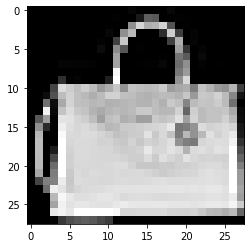

In [112]:
from pkgutil import get_data
import onnx.numpy_helper as nph
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

DATASET_ROOT = "/workspace/finn/src/data/fashion"
test_data = torchvision.datasets.FashionMNIST(DATASET_ROOT, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False)

images, labels = next(iter(testloader))
testImage = images[30]
plt.imshow(testImage.reshape(28,28), cmap='gray')

In [113]:
model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_pynqZ2_deploy.onnx")
iname = model.graph.input[0].name
ishape = model.get_tensor_shape(iname)
print("Expected network input shape is " + str(ishape))

import numpy as np
import bitstring
from finn.core.onnx_exec import execute_onnx

test = testImage[0].numpy()*255

input_dict = {iname: test.reshape(ishape)}
ret = execute_onnx(model, input_dict, False)

classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', \
           'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

classes[int(ret["global_out"])]

Expected network input shape is [1, 28, 28, 1]


'bag'

In [93]:
from finn.core.throughput_test import throughput_test_remote

model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_pynqZ2_deploy.onnx")
res = throughput_test_remote(model, 10000)
print("Network metrics:")
for key in res:
    print(str(key) + ": " + str(res[key]))

Network metrics:
runtime[ms]: 971.9593524932861
throughput[images/s]: 10288.496092298341
DRAM_in_bandwidth[Mb/s]: 8.0661809363619
DRAM_out_bandwidth[Mb/s]: 0.01028849609229834
fclk[mhz]: 100.0
N: 10000
